In [6]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
%matplotlib inline

In [2]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))
        

class ProteinCnnModel2(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 3)
    
    def forward(self, xb):
#         return torch.sigmoid(self.network(xb))
        return F.softmax(self.network(xb), dim=1)

In [3]:
model = ProteinCnnModel2()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(device)
model.to(device)
#### for trained weights ###
model.load_state_dict(torch.load('resnet_signlang_andrew_v3.pth'))
model.eval()

cuda


ProteinCnnModel2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [4]:
labels = {
    0: 'zero',
    1: 'five',
    2: 'three'
}


def encode_label(label):
    target = torch.zeros(3)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)



def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


def show_sample(img, target, invert=True):
    plt.imshow(img.permute(1, 2, 0))
#     plt.imshow(img)
    print('Labels:', decode_target(target, text_labels=True))
    

def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

Prediction:  tensor([0.3640, 0.1930, 0.4430], device='cuda:0', grad_fn=<SelectBackward>)
Labels: 


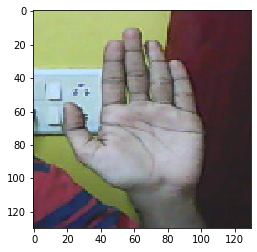

In [10]:
# sm_img = 'fingerspelling5/dataset5/andy/f/color_5_0007.png'
sm_img = 'threeyo.jpg'
# sm_img = 'zero.jpg'
# sm_img = 'crped.jpg'
# sm_img = 'five.jpg'
sm_img = 'flip_five.jpg'
# ImageOps.mirror(im)
img = Image.open(sm_img).resize((130,130))
img = ImageOps.mirror(img)
img = ToTensor()(img)
# print(img)
# print(img.size())
predict_single(img)

In [11]:
import cv2
import numpy as np
cap = cv2.VideoCapture(0)

In [12]:
runto= 0
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame[235:239,495:499,:] = 100
    cropped_frame = frame[240:,500:,:]
#     cropped_frame = np.rollaxis(cropped_frame, 3, 1) 
    np_img = Image.fromarray(cropped_frame)
    img = np_img.resize((130,130))
    img = ToTensor()(img)
    runto = runto + 1
    if runto==100:
        break
#     predict_single(img)

Prediction:  tensor([0.8193, 0.0419, 0.1389], device='cuda:0', grad_fn=<SelectBackward>)
Labels: zero(0)


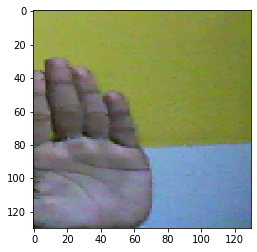

In [14]:
predict_single(img)

In [13]:
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [25]:
cv2.imshow('frame',frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [1]:
import jovian

In [2]:
jovian.commit(project='Course-Project-Compiled')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Creating a new project "andrew2moses/Course-Project-Compiled"
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ml/andrew2moses/course-project-compiled


'https://jovian.ml/andrew2moses/course-project-compiled'